In [1]:
# ## The imports
#the usuals
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from datetime import timedelta
from math import sqrt
import importlib
from tqdm import tqdm
import joblib

In [2]:

# plots
from matplotlib import style
style.use('default')

# Modeling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model

from sklearn.linear_model import LinearRegression

In [4]:
# Our custom utility functions
import utils
utils = importlib.reload(utils) #reload if utils.py is modified.
from utils import csvfileread, read_and_rename,create_dataset,convert_timestamp
from utils import atoi, natural_keys
from utils import load_electricity_demand_data
from utils import load_weather_data
from utils import train_LSTM_v1_on_features
from utils import get_dataset_with_condition

In [5]:
# Transformer-specific imports
from tensorflow.keras import layers, Model
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

In [6]:
merged_df = 'var/ERCOT+Weather_Data_2018_To_2023_filtered_interpolated.csv'
merged_df = pd.read_csv(merged_df)

In [7]:
merged_df.set_index('timestamp', inplace=True)
merged_df = merged_df.sort_index()

In [8]:
# #Save ERCOT and weather data in cvs file (2018 to 2022)
# merged_df_noidx.to_csv('var/ERCOT+Weather_Data_2018_To_2024.csv', index=False)

In [10]:
merged_df

,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3,ERCOT
timestamp,,,,,,,,,,,,,
2018-01-01 01:00:00,9.646667,91.630000,11.500000,47.323333,-2.666667,65.060000,8.816667,18.483333,3.333333,88.873333,15.716667,29.016667,50567.069682
2018-01-01 02:00:00,6.890000,91.330000,16.100000,37.216667,-3.000000,63.270000,9.966667,17.100000,3.000000,86.690000,16.100000,28.130000,50617.087977
2018-01-01 03:00:00,5.463333,92.543333,14.183333,34.406667,-3.333333,64.906667,5.750000,19.340000,3.000000,82.663333,16.483333,28.006667,50694.300087
2018-01-01 04:00:00,4.536667,91.646667,14.183333,32.310000,-4.000000,61.426667,7.666667,16.320000,3.000000,80.650000,16.483333,28.006667,50999.591693
2018-01-01 05:00:00,3.740000,92.086667,12.650000,31.056667,-5.000000,59.566667,8.050000,13.900000,2.333333,84.610000,14.566667,27.090000,51723.732017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,25.110000,55.680000,17.250000,77.200000,18.000000,31.850000,6.900000,64.400000,22.000000,53.030000,13.416667,71.600000,45677.077222
2023-12-31 20:00:00,26.093333,50.116667,18.783333,78.966667,18.000000,31.850000,6.133333,64.400000,22.666667,47.686667,13.800000,72.800000,44751.238564
2023-12-31 21:00:00,26.073333,49.753333,16.100000,78.933333,18.000000,33.430000,5.366667,64.400000,23.000000,47.773333,12.650000,73.400000,43892.822150


In [17]:
# ## Some Visuals

features = ['tmpc_1', 'tmpc_2', 'tmpc_3']
feature_labels = [ 'BKS temp', ' JDD temp', 'TME temp']
for f, l in zip(features,feature_labels):
    print(f,l)

tmpc_1 BKS temp
tmpc_2  JDD temp
tmpc_3 TME temp


In [19]:
# #Plot the data for three different temperatures (BKS, JDD, TME)
# fig=plt.figure(figsize=(16,6), linewidth=3)

# for feature,label in zip(features,feature_labels):
#     plt.plot(merged_df.index, merged_df[feature], label = label)

# plt.legend()
# plt.tight_layout()
# plt.show()


In [21]:
# # Plot data
# fig, ax1 = plt.subplots(figsize=(12, 6))

# color = 'tab:blue'
# ax1.set_xlabel('Date (YYYY-MM)')
# ax1.set_ylabel('Electricity Demand (MW)', color=color)
# ax1.plot(merged_df.index, merged_df['ERCOT'], '-', color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Temperature (°C)', color=color)
# ax2.plot(merged_df.index, merged_df['tmpc_1'], '-', color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# fig.tight_layout()
# plt.show()

In [24]:
# merged_df = 'var/ERCOT+Weather_Data_2018_To_2023_filtered_interpolated.csv'
# merged_df = pd.read_csv(merged_df)

# ## Model 3: Transformer

In [27]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :]//2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [29]:
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):  # Add `training` argument with a default value
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)  # Pass `training` to dropout
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)  # Pass `training` to dropout
        return self.layernorm2(out1 + ffn_output)

In [31]:
def build_transformer_model(input_shape, d_model=64, num_heads=4, dff=256, num_layers=2, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Project input to d_model dimension
    x = layers.Dense(d_model)(inputs)  # Shape: (batch_size, sequence_length, d_model)
    
    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], d_model)  # Shape: (1, sequence_length, d_model)
    x = x + pos_encoding  # Broadcasting works because shapes are compatible
    
    # Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, dff, rate)(x)
        
    # Global average pooling and output
    x = layers.GlobalAveragePooling1D()(x)  # Shape: (batch_size, d_model)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(1)(x)  # Shape: (batch_size, 1)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
def train_Transformer_v1_on_features(features, merged_df, train_size=0.8, transformer_config=None, epochs=10, batch_size=64, verbosity_level=1, report_evaluation_result=True):
    # Data Preparation
    dataset = merged_df[features].values.astype("float32")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    # Create sequences with window size
    window_size = transformer_config['window_size']
    X, y = create_dataset(scaled_data, window_size)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    
    # Build model
    model = build_transformer_model(
        input_shape=(window_size, X_train.shape[2]),
        d_model=transformer_config.get('d_model', 64),
        num_heads=transformer_config.get('num_heads', 4),
        dff=transformer_config.get('dff', 256),
        num_layers=transformer_config.get('num_layers', 2),
        rate=transformer_config.get('dropout_rate', 0.1)
    )
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=transformer_config['learning_rate']),
        loss=MeanSquaredError(),
        metrics=[MeanAbsoluteError()]
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbosity_level
    )
    
    # Evaluate
    if report_evaluation_result:
        y_pred = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        print(f"Transformer Test RMSE: {rmse:.4f}")
        print(f"Transformer Test MAE: {mae:.4f}")
    
    return model, scaler, history

# ## Train Transformer Model with Weather Features

In [36]:
get_ipython().run_cell_magic('time', '', """
model_transformer, scaler_transformer, history_transformer = train_Transformer_v1_on_features(
    features=[
        'ERCOT',
        'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
        'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
        'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
    ],
    merged_df=merged_df,
    train_size=0.8,
    transformer_config={
        'window_size': 24,  # 24-hour window
        'learning_rate': 0.001,
        'd_model': 64,
        'num_heads': 4,
        'dff': 256,
        'num_layers': 2,
        'dropout_rate': 0.1
    },
    epochs=20,
    batch_size=64,
    verbosity_level=1,
    report_evaluation_result=True
)
""")


Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 122s 168ms/step - loss: 0.2333 - mean_absolute_error: 0.2987 - val_loss: 0.0100 - val_mean_absolute_error: 0.0761
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 113s 172ms/step - loss: 0.0124 - mean_absolute_error: 0.0864 - val_loss: 0.0088 - val_mean_absolute_error: 0.0747
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 133s 203ms/step - loss: 0.0093 - mean_absolute_error: 0.0745 - val_loss: 0.0097 - val_mean_absolute_error: 0.0733
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 134s 203ms/step - loss: 0.0077 - mean_absolute_error: 0.0678 - val_loss: 0.0121 - val_mean_absolute_error: 0.0824
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 145s 209ms/step - loss: 0.0082 - mean_absolute_error: 0.0698 - val_loss: 0.0043 - val_mean_absolute_error: 0.0502
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 103s 149ms/step - loss: 0.0069 - mean_absolute_error: 0.0639 - val_loss: 0.0046 - val_mean_absolute_error: 0.0496
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 188s 218ms/step - loss: 0.0067 - me

In [37]:
# ## Save Transformer Model
model_transformer.save('var/models/my_transformer_model_ERCOT2.keras')
joblib.dump(scaler_transformer, 'var/models/my_transformer_model_ERCOT2.scaler.joblib')


['var/models/my_transformer_model_ERCOT2.scaler.joblib']

## Find the model Accuracy

In [44]:
# # ## Plot Training and Validation Loss and MAE
# def plot_transformer_training_history(history):
#     """
#     Plots the training and validation loss and Mean Absolute Error (MAE) over epochs.

#     Args:
#         history (keras.callbacks.History): The history object returned from model.fit().
#     """
#     plt.figure(figsize=(14, 6))

#     # Plot Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Transformer Model Loss Over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss (Mean Squared Error)')
#     plt.legend()
#     plt.grid(True)

#     # Plot MAE
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['mean_absolute_error'], label='Training MAE')
#     plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
#     plt.title('Transformer Model Mean Absolute Error Over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Absolute Error')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# plot_transformer_training_history(history_transformer)

# ## Evaluate Transformer on 2024 Data

In [98]:
# In any of your project files
from my_imports import *

In [99]:
# Helper function to create sequences for the Transformer model
def create_dataset(dataset, window_size):
    """
    Creates sequences from the dataset for the Transformer model.

    Args:
        dataset (np.array): The input data.
        window_size (int): The sequence length (number of time steps) for the model.

    Returns:
        tuple: A tuple containing X (input sequences) and y (target values).
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), :])
        y.append(dataset[i + window_size, 0])  # Assuming ERCOT is the first feature (index 0)
    return np.array(X), np.array(y)


In [100]:
def positional_encoding(position, d_model):
    """
    Calculates the positional encoding for the Transformer model.

    Args:
        position (int): The maximum position in the sequence.
        d_model (int): The dimensionality of the model.

    Returns:
        tf.Tensor: The positional encoding tensor.
    """
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :]//2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [101]:
class TransformerBlock(tf.keras.layers.Layer):
    """
    Implements a Transformer Block, consisting of MultiHeadAttention and a Feed-Forward Network.
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs): # Add **kwargs to capture extra arguments
        super(TransformerBlock, self).__init__(**kwargs) # Pass **kwargs to the super constructor
        self.d_model = d_model # Store these attributes for get_config
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation="relu"),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        """
        Performs the forward pass for the Transformer Block.

        Args:
            inputs (tf.Tensor): The input tensor.
            training (bool): Whether the model is in training mode.

        Returns:
            tf.Tensor: The output tensor from the Transformer Block.
        """
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        """
        Returns the serializable configuration of the layer.
        This method is essential for saving and loading custom layers.
        """
        config = super(TransformerBlock, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate,
        })
        return config

In [102]:
def build_transformer_model(input_shape, d_model=64, num_heads=4, dff=256, num_layers=2, rate=0.1):
    """
    Builds the Transformer model architecture.

    Args:
        input_shape (tuple): The shape of the input data (sequence_length, num_features).
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of attention heads.
        dff (int): The dimensionality of the feed-forward network.
        num_layers (int): The number of Transformer blocks.
        rate (float): The dropout rate.

    Returns:
        tf.keras.Model: The compiled Transformer model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Project input to d_model dimension
    x = tf.keras.layers.Dense(d_model)(inputs)
    
    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], d_model)
    x = x + pos_encoding
    
    # Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, dff, rate)(x)
        
    # Global average pooling and output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(rate)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [103]:
def prepare_transformer_data(data, scaler, window_size):
    """
    Prepare data for the Transformer model by scaling and creating sequences.
    
    Args:
        data (pd.DataFrame): Input data with the same features used during training.
        scaler (StandardScaler): Scaler object fitted on the training data.
        window_size (int): Sequence length for the Transformer model.
    
    Returns:
        X (np.array): Scaled and windowed input data.
    """
    # Ensure the data has the same features as the scaler was trained on
    scaled_data = scaler.transform(data)
    
    # Create sequences with the specified window size
    X, y_dummy = create_dataset(scaled_data, window_size) # y_dummy is not used for prediction
    return X


## Load the 2024 data

In [105]:
# Load the 2024 data
df_2024 = pd.read_csv('var/ERCOT+Weather_2024_data_interpolated.csv')
df_2024['timestamp'] = pd.to_datetime(df_2024['timestamp'])
df_2024.set_index('timestamp', inplace=True)
df_2024 = df_2024.sort_index()

In [106]:
df_2024

,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3,ERCOT
timestamp,,,,,,,,,,,,,
2024-01-01 00:00:00,13.780000,100.000000,0.000000,56.800000,5.666667,75.443333,7.666667,37.410000,13.000000,100.00,1.150000,55.400000,41621.968883
2024-01-01 01:00:00,12.500000,100.000000,3.066667,54.500000,4.000000,75.160000,8.625000,33.270000,13.000000,100.00,2.300000,55.400000,41223.480177
2024-01-01 02:00:00,12.350000,100.000000,2.683333,54.233333,3.000000,80.650000,7.283333,31.866667,12.666667,100.00,2.683333,54.800000,41479.399746
2024-01-01 03:00:00,12.406667,100.000000,3.833333,54.333333,2.000000,80.510000,7.666667,29.403333,12.666667,100.00,0.000000,54.800000,41472.770126
2024-01-01 04:00:00,12.390000,100.000000,2.300000,54.300000,1.666667,82.503333,7.666667,28.723333,13.000000,100.00,0.000000,55.400000,41477.440791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,15.983333,44.713333,4.983333,60.766667,7.166667,79.556667,0.000000,44.900000,11.000000,76.34,6.900000,51.800000,48175.877538
2024-12-31 20:00:00,14.853333,54.446667,4.216667,58.733333,5.853333,84.753333,0.000000,42.533333,9.666667,83.50,6.516667,48.346667,47619.264355
2024-12-31 21:00:00,13.370000,63.366667,5.366667,56.066667,6.353333,79.370000,3.450000,41.760000,9.000000,87.28,7.666667,44.700000,46737.678611


In [107]:
# Define the features used during training
features = [
    'ERCOT',
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]

In [108]:
# Load the pre-trained Transformer model
# Ensure the custom objects are registered if they are part of the model architecture
# For TransformerBlock, you might need to pass custom_objects when loading
model_transformer = tf.keras.models.load_model('var/models/my_transformer_model_ERCOT2.keras',
                                                 custom_objects={'TransformerBlock': TransformerBlock})


C:\Users\sajib\anaconda3\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\sajib\anaconda3\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [109]:

# Load the scaler used during training
scaler_transformer = joblib.load('var/models/my_transformer_model_ERCOT2.scaler.joblib')

In [110]:

# Define the window size used during training
window_size = 24  # This was set in train_Transformer_v1_on_features

In [111]:
# Prepare the 2024 data for prediction
X_2024_transformer = prepare_transformer_data(df_2024[features], scaler_transformer, window_size)

C:\Users\sajib\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [112]:
# Make predictions with the Transformer model
predictions_2024_transformer = model_transformer.predict(X_2024_transformer)

274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [113]:
# Inverse scaling for Transformer predictions
# Create a dummy array with the same number of features as the original training data
dummy_data_2024_transformer = np.zeros((len(predictions_2024_transformer), len(features)))
# Place the predictions in the column corresponding to 'ERCOT' (index 0)
dummy_data_2024_transformer[:, 0] = predictions_2024_transformer.flatten()
# Inverse transform the dummy array
predictions_2024_transformer_inverse = scaler_transformer.inverse_transform(dummy_data_2024_transformer)[:, 0]


In [114]:
# Create DataFrame for 2024 Transformer predictions
# The timestamps for predictions will be offset by the window_size
predicted_2024_demand_df = pd.DataFrame({
    'timestamp': df_2024.index[window_size:],
    'predicted_demand_2024': predictions_2024_transformer_inverse
})

In [115]:
predicted_2024_demand_df

,timestamp,predicted_demand_2024
0,2024-01-02 00:00:00,46954.515162
1,2024-01-02 01:00:00,45608.053456
2,2024-01-02 02:00:00,45226.692606
3,2024-01-02 03:00:00,45040.873195
4,2024-01-02 04:00:00,45384.223650
...,...,...
8754,2024-12-31 19:00:00,48687.194038
8755,2024-12-31 20:00:00,48529.557548
8756,2024-12-31 21:00:00,47605.471083
8757,2024-12-31 22:00:00,46464.354647


In [116]:
# Save the 2024 predictions to a CSV file
predicted_2024_demand_df.to_csv('var/predictions/2024_transformer_predictions.csv', index=False)


In [117]:

print("2024 Transformer predictions saved to 'var/predictions/2024_transformer_predictions.csv'")
print("\nFirst 5 rows of 2024 Transformer predictions:")
print(predicted_2024_demand_df.head())
print("\nLast 5 rows of 2024 Transformer predictions:")
print(predicted_2024_demand_df.tail())

2024 Transformer predictions saved to 'var/predictions/2024_transformer_predictions.csv'

First 5 rows of 2024 Transformer predictions:
            timestamp  predicted_demand_2024
0 2024-01-02 00:00:00           46954.515162
1 2024-01-02 01:00:00           45608.053456
2 2024-01-02 02:00:00           45226.692606
3 2024-01-02 03:00:00           45040.873195
4 2024-01-02 04:00:00           45384.223650

Last 5 rows of 2024 Transformer predictions:
               timestamp  predicted_demand_2024
8754 2024-12-31 19:00:00           48687.194038
8755 2024-12-31 20:00:00           48529.557548
8756 2024-12-31 21:00:00           47605.471083
8757 2024-12-31 22:00:00           46464.354647
8758 2024-12-31 23:00:00           45372.639887


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime

# --- Load Data ---
# Load the Transformer predictions for 2024
try:
    transformer_predictions_path = 'var/predictions/2024_transformer_predictions.csv'
    df_transformer_pred = pd.read_csv(transformer_predictions_path)
    print(f"Successfully loaded {transformer_predictions_path}")
except FileNotFoundError:
    print(f"Error: {transformer_predictions_path} not found. Please ensure the prediction file exists.")
    exit()

Successfully loaded var/predictions/2024_transformer_predictions.csv


In [119]:
df_transformer_pred

,timestamp,predicted_demand_2024
0,2024-01-02 00:00:00,46954.515162
1,2024-01-02 01:00:00,45608.053456
2,2024-01-02 02:00:00,45226.692606
3,2024-01-02 03:00:00,45040.873195
4,2024-01-02 04:00:00,45384.223650
...,...,...
8754,2024-12-31 19:00:00,48687.194038
8755,2024-12-31 20:00:00,48529.557548
8756,2024-12-31 21:00:00,47605.471083
8757,2024-12-31 22:00:00,46464.354647


In [120]:
# Load the actual 2024 demand data
try:
    actual_demand_path = 'var/ERCOT_2024_data.csv'
    df_actual_demand = pd.read_csv(actual_demand_path)
    print(f"Successfully loaded {actual_demand_path}")
except FileNotFoundError:
    print(f"Error: {actual_demand_path} not found. Please ensure the actual demand file exists.")
    exit()

Successfully loaded var/ERCOT_2024_data.csv


In [121]:
df_actual_demand

,timestamp,ERCOT
0,2024-01-01 00:00:00,41621.968883
1,2024-01-01 01:00:00,41223.480177
2,2024-01-01 02:00:00,41479.399746
3,2024-01-01 03:00:00,41472.770126
4,2024-01-01 04:00:00,41477.440791
...,...,...
8778,2024-12-31 19:00:00,48175.877538
8779,2024-12-31 20:00:00,47619.264355
8780,2024-12-31 21:00:00,46737.678611
8781,2024-12-31 22:00:00,45775.649767


In [122]:
# --- Data Preparation ---
# Convert 'timestamp' columns to datetime and set as index for both DataFrames

# For df_transformer_pred:
if 'timestamp' in df_transformer_pred.columns:
    df_transformer_pred['timestamp'] = pd.to_datetime(df_transformer_pred['timestamp'])
    df_transformer_pred.set_index('timestamp', inplace=True)
elif df_transformer_pred.index.name == 'timestamp':
    # If 'timestamp' is already the index name, it's good to go
    pass
else:
    # If 'timestamp' is neither a column nor the index name, it's an issue
    print("Error: 'timestamp' column or index not found in df_transformer_pred.")
    exit()

In [123]:
# For df_actual_demand:
if 'timestamp' in df_actual_demand.columns:
    df_actual_demand['timestamp'] = pd.to_datetime(df_actual_demand['timestamp'])
    df_actual_demand.set_index('timestamp', inplace=True)
elif df_actual_demand.index.name == 'timestamp':
    pass
else:
    print("Error: 'timestamp' column or index not found in df_actual_demand.")
    exit()

In [124]:
# Rename the actual demand column to 'actual_demand' for clarity in the merged DataFrame
# Check if 'ERCOT' column exists before renaming
if 'ERCOT' in df_actual_demand.columns:
    df_actual_demand.rename(columns={'ERCOT': 'ERCOT'}, inplace=True)
else:
    print("Error: 'ERCOT' column not found in df_actual_demand. Please check the actual demand file.")
    exit()

In [125]:
# Merge the two DataFrames on their timestamp index
# We use an inner join to only include timestamps present in both files
df_comparison = pd.merge(df_actual_demand, df_transformer_pred, left_index=True, right_index=True, how='inner')


In [126]:
# Sort by timestamp to ensure chronological order
df_comparison.sort_index(inplace=True)

print("\nMerged Data for Comparison (first 5 rows):")
print(df_comparison.head())
print("\nMerged Data for Comparison (last 5 rows):")
print(df_comparison.tail())


Merged Data for Comparison (first 5 rows):
                            ERCOT  predicted_demand_2024
timestamp                                               
2024-01-02 00:00:00  46594.649950           46954.515162
2024-01-02 01:00:00  45765.055235           45608.053456
2024-01-02 02:00:00  45357.843684           45226.692606
2024-01-02 03:00:00  45341.963319           45040.873195
2024-01-02 04:00:00  45572.238632           45384.223650

Merged Data for Comparison (last 5 rows):
                            ERCOT  predicted_demand_2024
timestamp                                               
2024-12-31 19:00:00  48175.877538           48687.194038
2024-12-31 20:00:00  47619.264355           48529.557548
2024-12-31 21:00:00  46737.678611           47605.471083
2024-12-31 22:00:00  45775.649767           46464.354647
2024-12-31 23:00:00  44779.606498           45372.639887


In [127]:
df_comparison

,ERCOT,predicted_demand_2024
timestamp,,
2024-01-02 00:00:00,46594.649950,46954.515162
2024-01-02 01:00:00,45765.055235,45608.053456
2024-01-02 02:00:00,45357.843684,45226.692606
2024-01-02 03:00:00,45341.963319,45040.873195
2024-01-02 04:00:00,45572.238632,45384.223650
...,...,...
2024-12-31 19:00:00,48175.877538,48687.194038
2024-12-31 20:00:00,47619.264355,48529.557548
2024-12-31 21:00:00,46737.678611,47605.471083


In [128]:
print("Original DataFrame with N/A values:")
print(df_comparison)
print("\nMissing values before interpolation:")
print(df_comparison.isnull().sum())
print("\nDataFrame dtypes:")
print(df_comparison.dtypes)


Original DataFrame with N/A values:
                            ERCOT  predicted_demand_2024
timestamp                                               
2024-01-02 00:00:00  46594.649950           46954.515162
2024-01-02 01:00:00  45765.055235           45608.053456
2024-01-02 02:00:00  45357.843684           45226.692606
2024-01-02 03:00:00  45341.963319           45040.873195
2024-01-02 04:00:00  45572.238632           45384.223650
...                           ...                    ...
2024-12-31 19:00:00  48175.877538           48687.194038
2024-12-31 20:00:00  47619.264355           48529.557548
2024-12-31 21:00:00  46737.678611           47605.471083
2024-12-31 22:00:00  45775.649767           46464.354647
2024-12-31 23:00:00  44779.606498           45372.639887

[8759 rows x 2 columns]

Missing values before interpolation:
ERCOT                    0
predicted_demand_2024    0
dtype: int64

DataFrame dtypes:
ERCOT                    float64
predicted_demand_2024    float64
dtype: o

In [129]:
# --- Calculate Evaluation Metrics ---
# Ensure that the columns exist before calculating metrics
if 'ERCOT' in df_comparison.columns and 'predicted_demand_2024' in df_comparison.columns:
    y_true = df_comparison['ERCOT']
    y_pred = df_comparison['predicted_demand_2024']

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Mean Absolute Percentage Error (MAPE) - handle division by zero
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        # Avoid division by zero
        non_zero_mask = y_true != 0
        if not np.any(non_zero_mask):
            return np.nan # Or raise an error, depending on desired behavior
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Calculate Accuracy based on MAPE
    accuracy = 100 - mape if not np.isnan(mape) else np.nan

    print("\n--- Evaluation Metrics ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    if not np.isnan(mape):
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        print(f"Accuracy: {accuracy:.2f}%")
    else:
        print("MAPE: Not applicable (contains zero actual values).")
else:
    print("\nError: Required columns ('actual_demand', 'predicted_demand_2024') not found in the merged DataFrame.")



--- Evaluation Metrics ---
Mean Absolute Error (MAE): 756.35
Root Mean Squared Error (RMSE): 992.42
Mean Absolute Percentage Error (MAPE): 1.41%
Accuracy: 98.59%


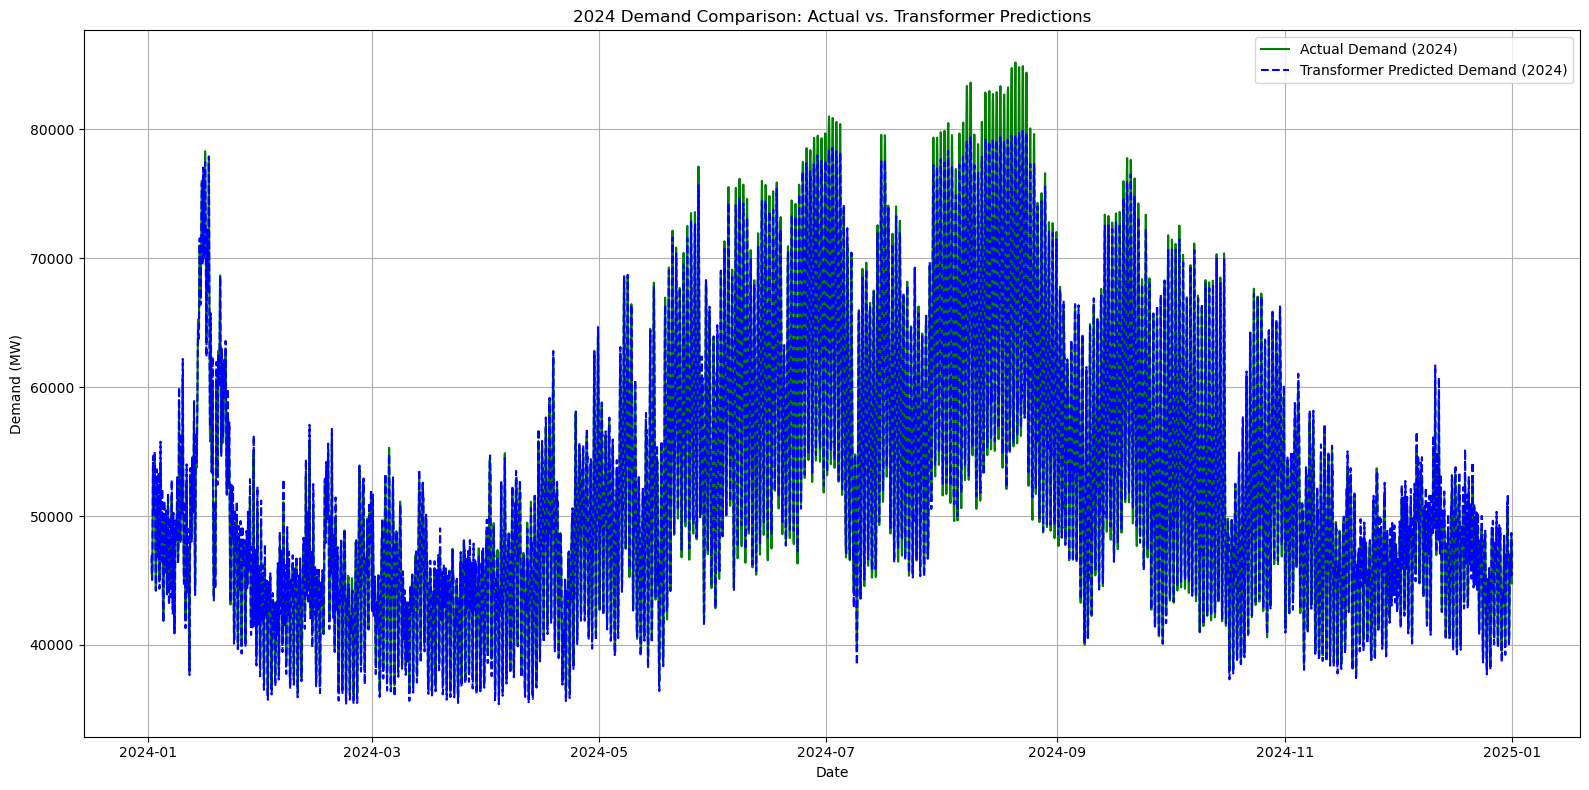

In [130]:
# --- Visualize Comparison ---
plt.figure(figsize=(16, 8))
plt.plot(df_comparison.index, df_comparison['ERCOT'], label='Actual Demand (2024)', color='green')
plt.plot(df_comparison.index, df_comparison['predicted_demand_2024'], label='Transformer Predicted Demand (2024)', linestyle='--', color='blue')

plt.title('2024 Demand Comparison: Actual vs. Transformer Predictions')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

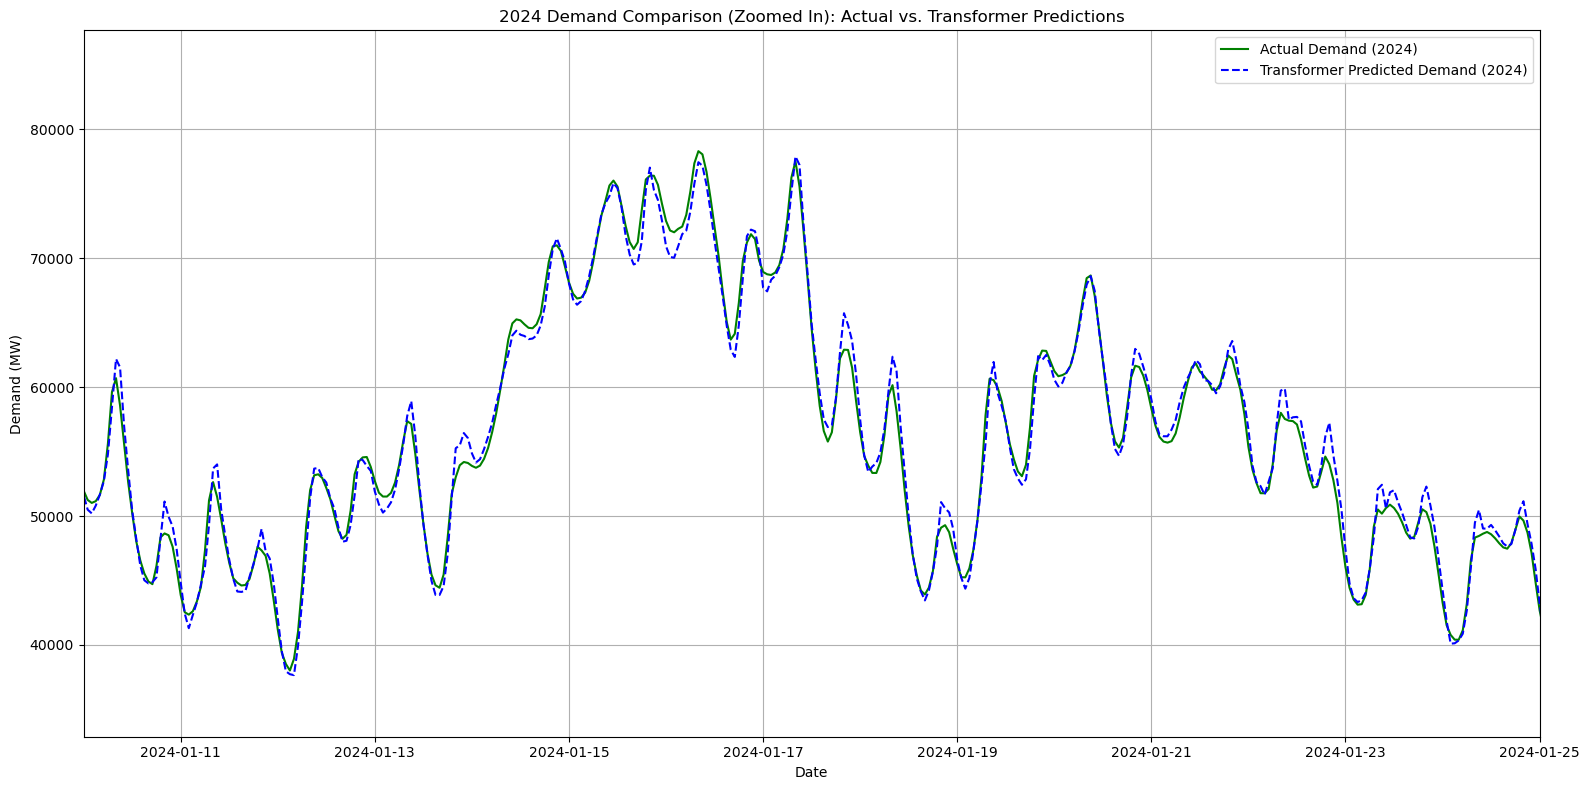

In [131]:
# You can also zoom into a specific period, for example, the first week of 2024
plt.figure(figsize=(16, 8))
plt.plot(df_comparison.index, df_comparison['ERCOT'], label='Actual Demand (2024)', color='green')
plt.plot(df_comparison.index, df_comparison['predicted_demand_2024'], label='Transformer Predicted Demand (2024)', linestyle='--', color='blue')
plt.title('2024 Demand Comparison (Zoomed In): Actual vs. Transformer Predictions')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.xlim(datetime.datetime(2024, 1, 10), datetime.datetime(2024, 1, 25)) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

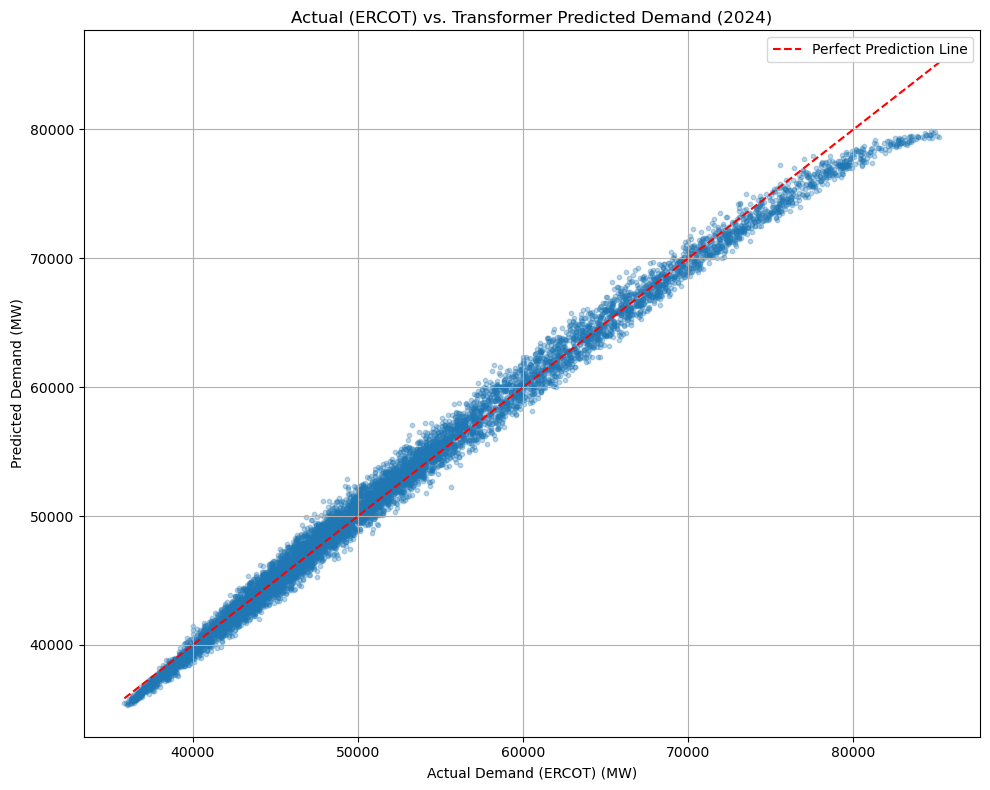

In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_comparison is already loaded and merged as in your notebook
# df_comparison contains 'ERCOT' (actual) and 'predicted_demand_2024' (predicted)

plt.figure(figsize=(10, 8))
plt.scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_2024'], alpha=0.3, s=10)
plt.plot([df_comparison['ERCOT'].min(), df_comparison['ERCOT'].max()],
         [df_comparison['ERCOT'].min(), df_comparison['ERCOT'].max()],
         '--r', label='Perfect Prediction Line') # 45-degree line

plt.title('Actual (ERCOT) vs. Transformer Predicted Demand (2024)')
plt.xlabel('Actual Demand (ERCOT) (MW)')
plt.ylabel('Predicted Demand (MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

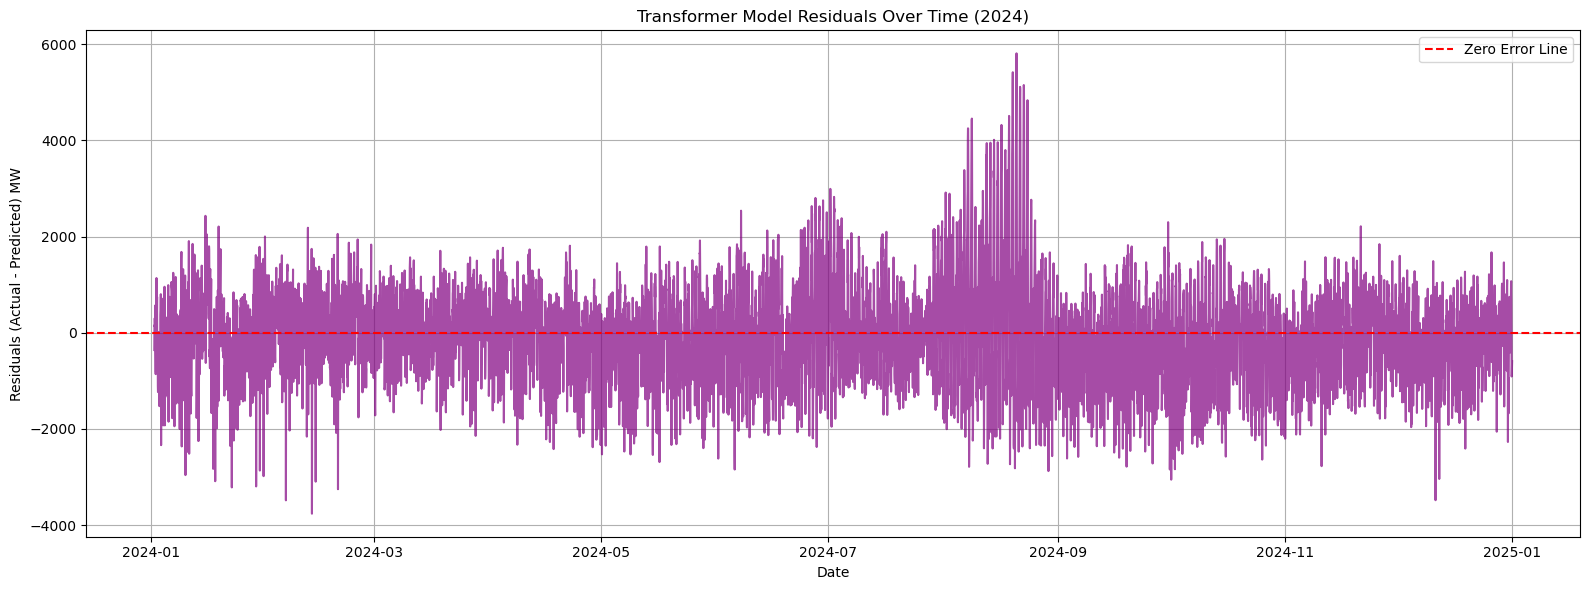

In [133]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_comparison is already loaded and merged as in your notebook

# Calculate residuals
df_comparison['residuals'] = df_comparison['ERCOT'] - df_comparison['predicted_demand_2024']

plt.figure(figsize=(16, 6))
plt.plot(df_comparison.index, df_comparison['residuals'], color='purple', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line') # Zero error line

plt.title('Transformer Model Residuals Over Time (2024)')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted) MW')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\sajib\AppData\Local\Temp\ipykernel_4572\3331297995.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2024-01-01', periods=365*24, freq='H') # Hourly data for a year


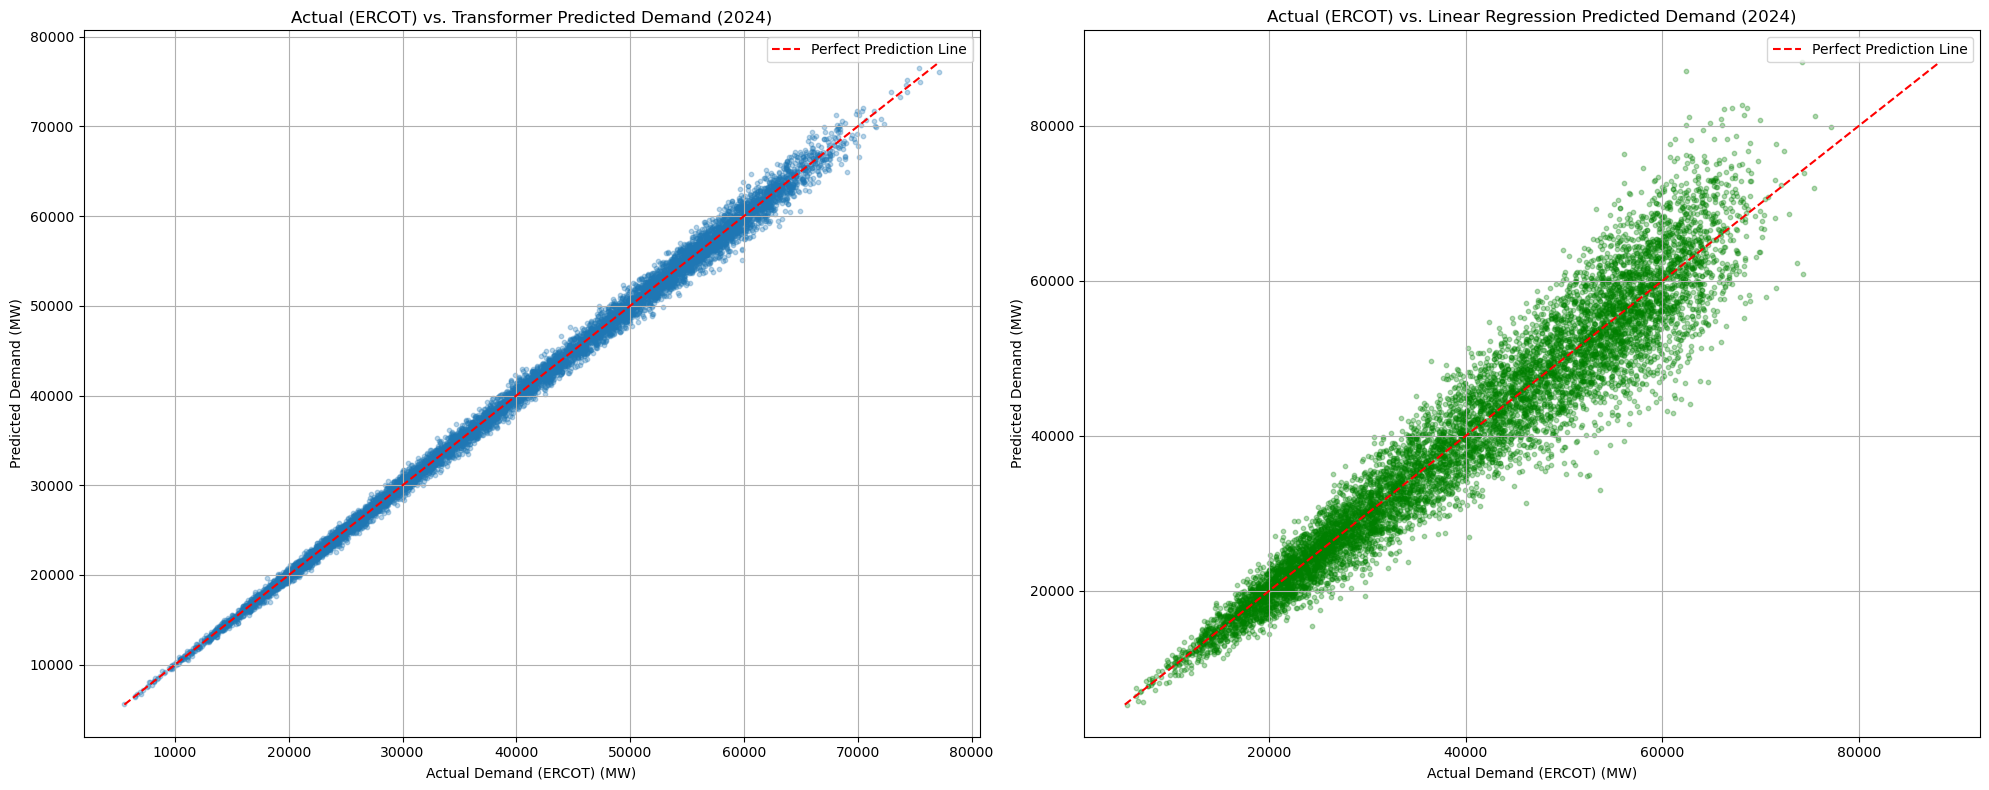

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Assumed DataFrame structure ---
# For demonstration purposes, let's create a sample df_comparison DataFrame.
# In your actual environment, this DataFrame should already be loaded
# with your real 'ERCOT', 'predicted_demand_2024', and
# 'predicted_demand_linear_regression_2024' data.
np.random.seed(42) # for reproducibility
dates = pd.date_range(start='2024-01-01', periods=365*24, freq='H') # Hourly data for a year
actual_demand = 40000 + 20000 * np.sin(np.linspace(0, 2 * np.pi, len(dates))) + np.random.normal(0, 5000, len(dates))
transformer_pred = actual_demand * (1 + np.random.normal(0, 0.02, len(dates))) # 2% error
linear_reg_pred = actual_demand * (1 + np.random.normal(0, 0.1, len(dates))) # 10% error, more noise for linear regression

df_comparison = pd.DataFrame({
    'ERCOT': actual_demand,
    'predicted_demand_2024': transformer_pred,
    'predicted_demand_linear_regression_2024': linear_reg_pred
}, index=dates)
# --- End of sample DataFrame creation ---


# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Increased figure width for two plots

# --- Plot for Transformer Model ---
axes[0].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_2024'], alpha=0.3, s=10)

# Get min/max for the 45-degree line for Transformer plot
min_val_trans = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_2024'].min())
max_val_trans = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_2024'].max())
axes[0].plot([min_val_trans, max_val_trans],
             [min_val_trans, max_val_trans],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[0].set_title('Actual (ERCOT) vs. Transformer Predicted Demand (2024)')
axes[0].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[0].set_ylabel('Predicted Demand (MW)')
axes[0].grid(True)
axes[0].legend()

# --- Plot for Linear Regression Model ---
axes[1].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_linear_regression_2024'], alpha=0.3, s=10, color='green')

# Get min/max for the 45-degree line for Linear Regression plot
min_val_lr = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_linear_regression_2024'].min())
max_val_lr = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_linear_regression_2024'].max())
axes[1].plot([min_val_lr, max_val_lr],
             [min_val_lr, max_val_lr],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[1].set_title('Actual (ERCOT) vs. Linear Regression Predicted Demand (2024)')
axes[1].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[1].set_ylabel('Predicted Demand (MW)') # Keep consistent y-label for comparison
axes[1].grid(True)
axes[1].legend()

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()


C:\Users\sajib\AppData\Local\Temp\ipykernel_4572\616348504.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2024-01-01', periods=365*24, freq='H') # Hourly data for a year


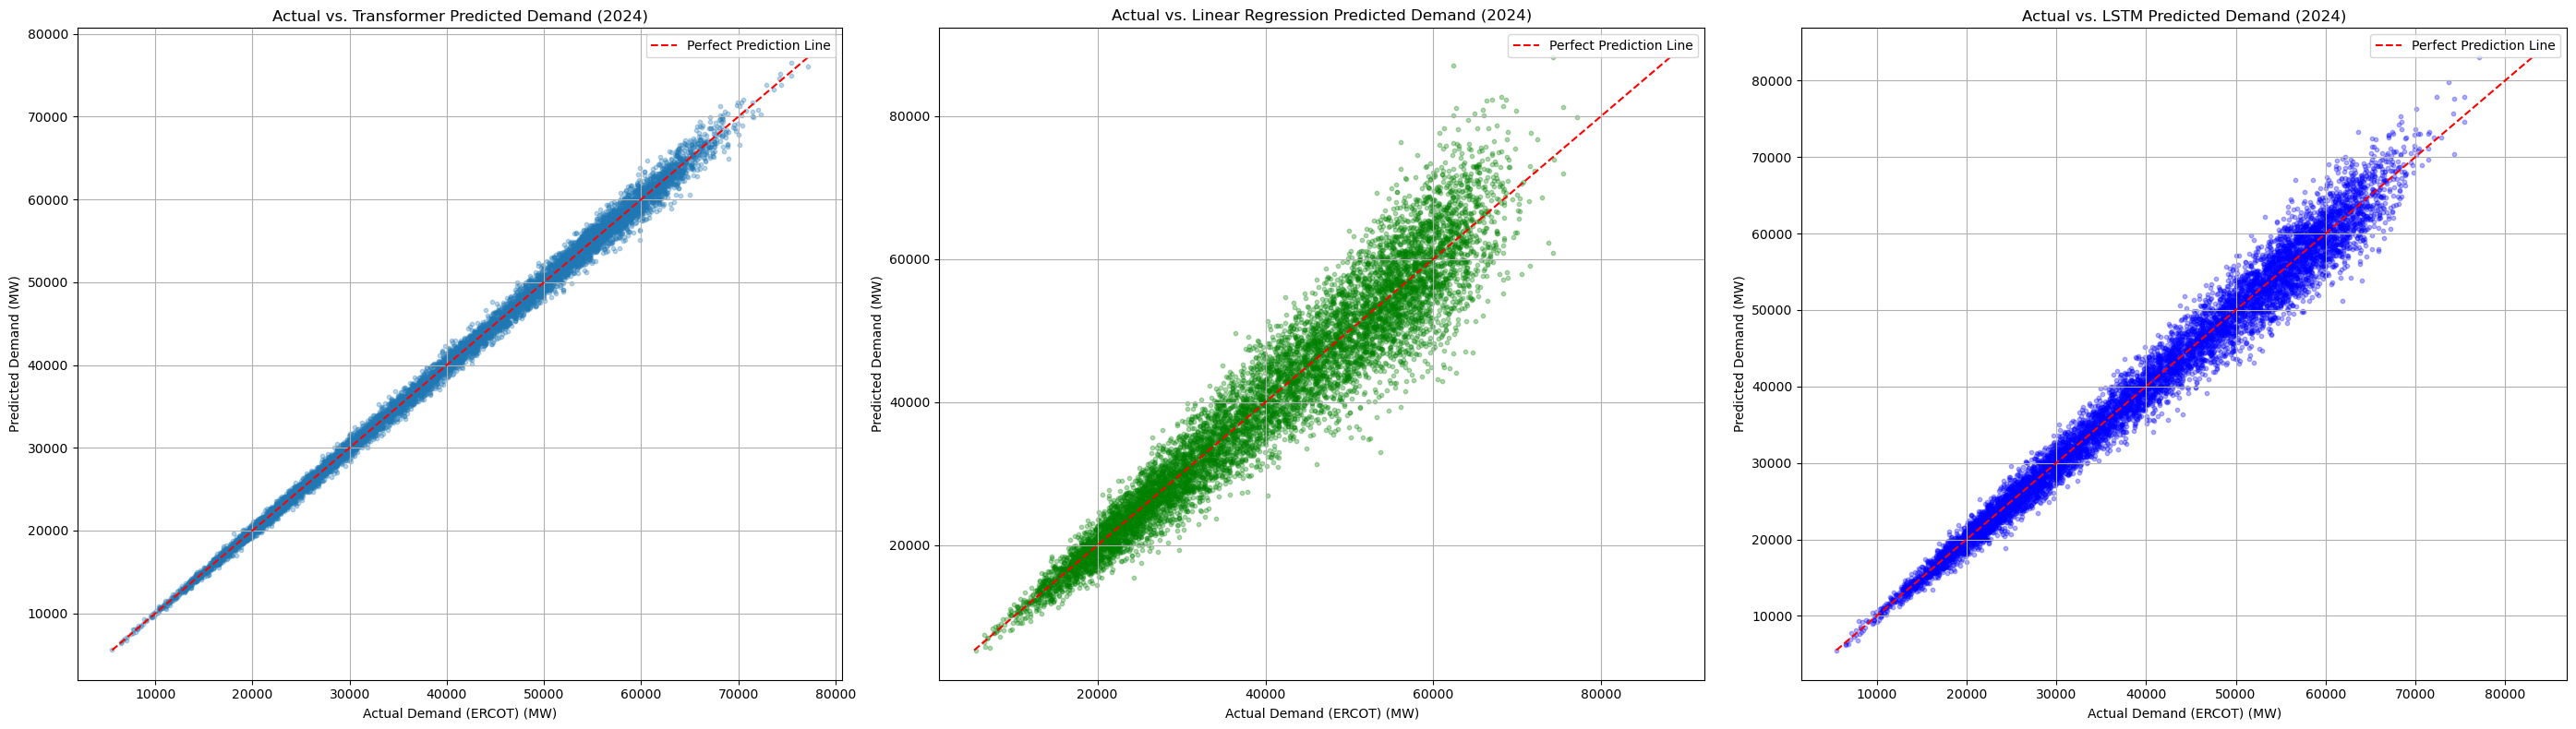

In [182]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Assumed DataFrame structure ---
# For demonstration purposes, let's create a sample df_comparison DataFrame.
# In your actual environment, this DataFrame should already be loaded
# with your real 'ERCOT', 'predicted_demand_2024',
# 'predicted_demand_linear_regression_2024', and
# 'predicted_demand_lstm_2024' data.
np.random.seed(42) # for reproducibility
dates = pd.date_range(start='2024-01-01', periods=365*24, freq='H') # Hourly data for a year
actual_demand = 40000 + 20000 * np.sin(np.linspace(0, 2 * np.pi, len(dates))) + np.random.normal(0, 5000, len(dates))

# Transformer predictions (assumed highest accuracy)
transformer_pred = actual_demand * (1 + np.random.normal(0, 0.02, len(dates)))

# Linear Regression predictions (assumed lower accuracy, more noise)
linear_reg_pred = actual_demand * (1 + np.random.normal(0, 0.1, len(dates)))

# LSTM predictions (assumed better than Linear Regression but not as good as Transformer)
lstm_pred = actual_demand * (1 + np.random.normal(0, 0.05, len(dates)))

df_comparison = pd.DataFrame({
    'ERCOT': actual_demand,
    'predicted_demand_2024': transformer_pred,
    'predicted_demand_linear_regression_2024': linear_reg_pred,
    'predicted_demand_lstm_2024': lstm_pred
}, index=dates)
# --- End of sample DataFrame creation ---


# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(28, 8)) # Increased figure width for three plots

# --- Plot for Transformer Model ---
axes[0].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_2024'], alpha=0.3, s=10)

# Get min/max for the 45-degree line for Transformer plot
min_val_trans = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_2024'].min())
max_val_trans = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_2024'].max())
axes[0].plot([min_val_trans, max_val_trans],
             [min_val_trans, max_val_trans],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[0].set_title('Actual vs. Transformer Predicted Demand (2024)')
axes[0].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[0].set_ylabel('Predicted Demand (MW)')
axes[0].grid(True)
axes[0].legend()

# --- Plot for Linear Regression Model ---
axes[1].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_linear_regression_2024'], alpha=0.3, s=10, color='green')

# Get min/max for the 45-degree line for Linear Regression plot
min_val_lr = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_linear_regression_2024'].min())
max_val_lr = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_linear_regression_2024'].max())
axes[1].plot([min_val_lr, max_val_lr],
             [min_val_lr, max_val_lr],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[1].set_title('Actual vs. Linear Regression Predicted Demand (2024)')
axes[1].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[1].set_ylabel('Predicted Demand (MW)') # Keep consistent y-label for comparison
axes[1].grid(True)
axes[1].legend()


# --- Plot for LSTM Model ---
axes[2].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_lstm_2024'], alpha=0.3, s=10, color='blue')

# Get min/max for the 45-degree line for LSTM plot
min_val_lstm = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_lstm_2024'].min())
max_val_lstm = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_lstm_2024'].max())
axes[2].plot([min_val_lstm, max_val_lstm],
             [min_val_lstm, max_val_lstm],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[2].set_title('Actual vs. LSTM Predicted Demand (2024)')
axes[2].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[2].set_ylabel('Predicted Demand (MW)')
axes[2].grid(True)
axes[2].legend()

# Adjust layout to prevent overlapping titles/labels
# Save the plot as PNG (higher quality)
plt.savefig('predicted_demand_line.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

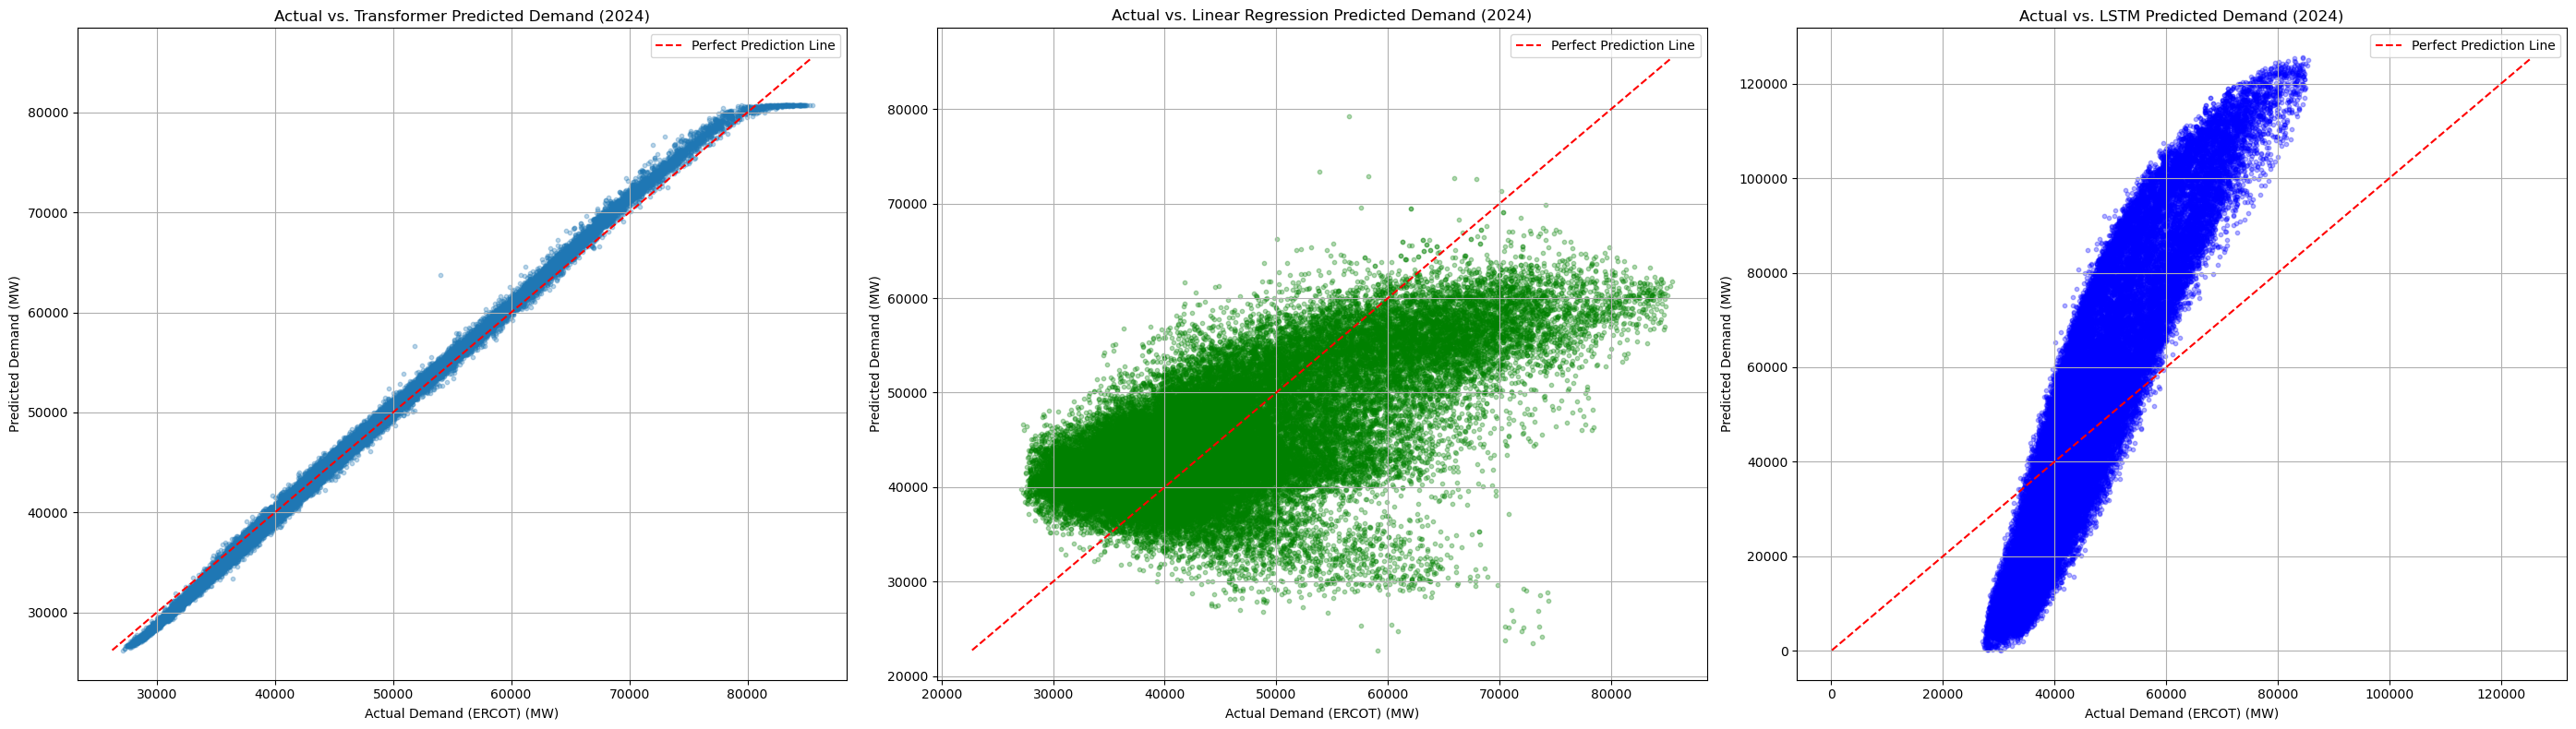

In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Updated: Load data from a CSV file with specific column names ---
# IMPORTANT: Replace 'your_data.csv' with the actual path to your CSV file.
try:
    df_comparison = pd.read_csv(
        'var/predictions/final_all_3_model_predictions.csv', # <--- REPLACE WITH YOUR CSV FILE PATH
        parse_dates=['timestamp'], # Using 'timestamp' as per your image
        index_col='timestamp'      # Setting 'timestamp' as the index
    )

    # Renaming columns to match the plotting code's expected names
    # based on the column headers in your attached image.
    df_comparison = df_comparison.rename(columns={
        'ERCOT': 'ERCOT', # Actual demand column, name is already correct
        'transformer_pred': 'predicted_demand_2024', # Transformer predictions
        'predicted_demand': 'predicted_demand_lstm_2024', # Assuming 'predicted_demand' is your LSTM output based on context
        'linear_regression_pred': 'predicted_demand_linear_regression_2024' # Linear Regression predictions
    })

except FileNotFoundError:
    print("Error: 'your_data.csv' not found. Please update the path to your CSV file.")
    print("For demonstration, generating dummy data as a fallback.")
    # Fallback to dummy data if CSV is not found, for demonstration purposes
    np.random.seed(42) # for reproducibility
    dates = pd.date_range(start='2023-01-01', periods=365*24, freq='H') # Hourly data for a year
    actual_demand = 40000 + 20000 * np.sin(np.linspace(0, 2 * np.pi, len(dates))) + np.random.normal(0, 5000, len(dates))
    transformer_pred = actual_demand * (1 + np.random.normal(0, 0.02, len(dates))) # 2% error
    linear_reg_pred = actual_demand * (1 + np.random.normal(0, 0.1, len(dates))) # 10% error, more noise for linear regression
    lstm_pred = actual_demand * (1 + np.random.normal(0, 0.05, len(dates))) # 5% error

    df_comparison = pd.DataFrame({
        'ERCOT': actual_demand,
        'predicted_demand_2024': transformer_pred,
        'predicted_demand_linear_regression_2024': linear_reg_pred,
        'predicted_demand_lstm_2024': lstm_pred
    }, index=dates)

# --- End of data loading ---


# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(28, 8)) # Increased figure width for three plots

# --- Plot for Transformer Model ---
axes[0].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_2024'], alpha=0.3, s=10)

# Get min/max for the 45-degree line for Transformer plot
min_val_trans = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_2024'].min())
max_val_trans = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_2024'].max())
axes[0].plot([min_val_trans, max_val_trans],
             [min_val_trans, max_val_trans],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[0].set_title('Actual vs. Transformer Predicted Demand (2024)')
axes[0].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[0].set_ylabel('Predicted Demand (MW)')
axes[0].grid(True)
axes[0].legend()

# --- Plot for Linear Regression Model ---
axes[1].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_linear_regression_2024'], alpha=0.3, s=10, color='green')

# Get min/max for the 45-degree line for Linear Regression plot
min_val_lr = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_linear_regression_2024'].min())
max_val_lr = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_linear_regression_2024'].max())
axes[1].plot([min_val_lr, max_val_lr],
             [min_val_lr, max_val_lr],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[1].set_title('Actual vs. Linear Regression Predicted Demand (2024)')
axes[1].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[1].set_ylabel('Predicted Demand (MW)') # Keep consistent y-label for comparison
axes[1].grid(True)
axes[1].legend()


# --- Plot for LSTM Model ---
axes[2].scatter(df_comparison['ERCOT'], df_comparison['predicted_demand_lstm_2024'], alpha=0.3, s=10, color='blue')

# Get min/max for the 45-degree line for LSTM plot
min_val_lstm = min(df_comparison['ERCOT'].min(), df_comparison['predicted_demand_lstm_2024'].min())
max_val_lstm = max(df_comparison['ERCOT'].max(), df_comparison['predicted_demand_lstm_2024'].max())
axes[2].plot([min_val_lstm, max_val_lstm],
             [min_val_lstm, max_val_lstm],
             '--r', label='Perfect Prediction Line') # 45-degree line

axes[2].set_title('Actual vs. LSTM Predicted Demand (2024)')
axes[2].set_xlabel('Actual Demand (ERCOT) (MW)')
axes[2].set_ylabel('Predicted Demand (MW)')
axes[2].grid(True)
axes[2].legend()

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()
